# Project 2 Report

**Authors**: *Azfarul Islam* and *Callum Abbott*

**Date**: December, 2020

---

# 🚦 Introduction

A primary method of reporting road traffic by the Department for Transport (DfT) involves estimating *Average Annual Daily Flow* (AADF) of traffic on UK roads. Counts are manually performed at pre-determined locations (called 'count points'), periodically. Typically, these counts are collected over a 12-hour period, only on weekdays, between March to October. There may be inconsistencies in which roads are counted, year on year.

Utilising the public dataset under an [Open Government License](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/), we explore it to understand and present our insights on traffic trends in Scotland (because we are at the University of Edinburgh, obviously) covering a period from 2000 to 2019.

---

# 📐 Approach

Before we begin deriving insights from our primary dataset, we decided to perform some basic exploratory data analysis (EDA) in order to understand what we are dealing with. This would also help us confirm which questions we thought would be interesting to answer, and consequently decide what appropriate transformations of the dataset would be deemed necessary.

Before we started any code development, we summarised the outcomes we wished to achieve for each visualisation. This was followed with a breakdown of steps we would need to take to arrive at our planned visualisation (e.g. figure formatting, external data, pivotting, etc.).

After these steps, if we found any alternative avenues of interest, we either added or pivoted towards those as appropriate.

---

### 🐲 *There be dragons (i.e. code begins)*

In [1]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FormatStrFormatter
import json
import os
import descartes
from shapely.geometry import Point, Polygon
from datetime import datetime

# Setting Pandas display parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

---

# 🧹🗺 Basic EDA

A quick set of EDA actions were performed where we simply observed the first few rows of data and referenced them against the descriptions for each column to ensure elements were as expected. We also utilised the `.info()` and `.describe()` methods for the dataframe to see the types of columns, as well as exploring summary statistics. 

Besides the specific questions we wanted to answer, this also helped us re-affirm any columns that we would not need to use.

---

### Exploring our data

In [2]:
# Read in data
df = pd.read_csv('data/dft_rawcount_region_id_3.csv', low_memory=False)

In [ ]:
df.head() # Quickly viewing variables

In [ ]:
df.describe(include='all') # Basic EDA

---

# 🧹 Tidying our data

Inspired by [TidyVerse](https://style.tidyverse.org) principles from R (thank you, *Hadley Wickham*), we decided to create a reduced data-frame which would only keep the signal and remove the noise, as it were. 

Here follows a set of transformations made to render our tidy dataframe.

### Removing unnecessary columns

Once we were mostly certain about the questions we wanted to answer, we could comfortably drop a large number of columns from the original dataframe. In some cases there was redundant data (such as `region_id` which contained only one value, or all the different types of HGV) in other cases, we simply did not need to keep that data. For HGVs, we only retained the `all_hgvs` column.

In [3]:
df_tidy = df.copy() # Tidy dataset storage

# Cols to drop
rm_cols = ['region_id', 'region_name', 'local_authority_id', 'road_type',
           'start_junction_road_name', 'end_junction_road_name',
           'year', 'easting', 'northing', 'link_length_miles', 'link_length_km', 'hgvs_2_rigid_axle',
           'hgvs_3_rigid_axle', 'hgvs_3_or_4_articulated_axle',
           'hgvs_4_or_more_rigid_axle', 'hgvs_5_articulated_axle',
           'hgvs_6_articulated_axle']

# Drop cols
df_tidy.drop(rm_cols, axis=1, inplace=True)

### Renaming Vehicle Labels 

We wanted to have more interpretable labels for each vehicle type, so we renamed them appropriately. This would make labelling in plots simpler.

In [4]:
new_names = ['bikes', 'motorcycles', 'cars', 'buses', 'lgvs', 'hgvs'] # More interpretable labels
name_mappings = dict(zip(df_tidy.columns[8:-1], new_names)) # Creating dict of label mappings
df_tidy.rename(columns=name_mappings, inplace=True) # Renaming columns

### Tidy Transformations

We noticed that there was a column called `all_motor_vehicles` which was a sum of counts per row for all vehicles save for bikes; we wanted to have a complete count which we called `all_vehicles`. 

As we knew we had interest in the type of road based on its letter designation, we utilised an anonymous function to extract that into a new column called `road_type`. Note that we dropped their original `road_type` column as we were not interested in it.]

Finally, we converted `count_date` to a `DateTime64` object, as we would utilise dates in a few of our questions.

In [5]:
# all_motor_vehicles --> all_vehicles (include bikes)
df_tidy['all_vehicles'] = df_tidy['bikes'] + df_tidy['motorcycles'] + df_tidy['cars'] + df_tidy['buses'] + \
                          df_tidy['lgvs'] + df_tidy['hgvs']

# New column for specifying whether road is: M, A, B, C, U
df_tidy = df_tidy.assign(
            road_type = lambda dataframe: dataframe['road_name'].map(lambda road_name: road_name[0]))

# Convert count_date to datetime format
df_tidy['count_date'] = pd.to_datetime(df['count_date'], format='%Y-%m-%d')

### Adding Population Data

We acquired population data covering mid-2019 estimates from [National Records of Scotland](https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019). Due to the Pandas-unfriendly structure of their dataset, we simply adapted it into a tiny dataset covering only the estimated populations for each local authority in Scotland.

We had to convert the `population` column into integers, and had to change the name of one of the local authorities (called, interchangeably: *Na h-Eileanan Siar*, *Comhairle nan Eilean Siar*, and *Eilean Siar*) to ensure there was parity across all dataframes. We merged the population data with our main dataframe.

⚠️ **Please note warning in code below**

In [6]:
# Read in population statistics
# Line(s) 5: National Records of Scotland
# URL: https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates/mid-year-population-estimates/mid-2019
# Accessed on 7th December 2020.
pop_df = pd.read_csv('data/scotland-mid-year-pop-est-19.csv', header=None)

# Rename columns
pop_df.rename(columns={0: 'local_authority_name', 1: 'population'}, inplace=True)

# Convert population to int
pop_df.population = pop_df.population.str.replace(',', '')
pop_df.population = pop_df.population.astype('int') 

# String replaces to avoid join issues
pop_df.local_authority_name = pop_df.local_authority_name.str.replace('Na h-Eileanan Siar', 'Eilean Siar')
df_tidy.local_authority_name = df_tidy.local_authority_name.str.replace('Comhairle nan Eilean Siar', 'Eilean Siar')
df_tidy.local_authority_name = df_tidy.local_authority_name.str.replace('&', 'and')

# Overwrite df_tidy with full outer join with population data`
# WARNING: this operation is idempotent so repeated runs will keep adding a population column
# Must restart kernel if this needs to be run again 
df_tidy = pd.merge(df_tidy, pop_df, on='local_authority_name', how='outer')

In [7]:
df_tidy.head(100) # Final check of tidy dataset

,count_point_id,direction_of_travel,count_date,hour,local_authority_name,road_name,latitude,longitude,bikes,motorcycles,cars,buses,lgvs,hgvs,all_motor_vehicles,all_vehicles,road_type,population
0,931907,N,2019-06-17,18,City of Edinburgh,U,55.967806,-3.307580,8,2,290,5,20,0,317,325,U,524930
1,931907,S,2019-06-17,13,City of Edinburgh,U,55.967806,-3.307580,1,1,258,4,36,7,306,307,U,524930
2,931907,N,2019-06-17,9,City of Edinburgh,U,55.967806,-3.307580,5,1,270,5,44,8,328,333,U,524930
3,931907,S,2019-06-17,12,City of Edinburgh,U,55.967806,-3.307580,2,2,266,4,50,9,331,333,U,524930
4,931907,S,2019-06-17,10,City of Edinburgh,U,55.967806,-3.307580,4,0,247,8,35,8,298,302,U,524930
5,931907,S,2019-06-17,16,City of Edinburgh,U,55.967806,-3.307580,7,3,475,5,101,7,591,598,U,524930
6,931907,N,2019-06-17,15,City of Edinburgh,U,55.967806,-3.307580,8,1,335,4,61,2,403,411,U,524930
7,931907,S,2019-06-17,15,City of Edinburgh,U,55.967806,-3.307580,10,3,447,5,91,8,554,564,U,524930
8,931907,N,2019-06-17,14,City of Edinburgh,U,55.967806,-3.307580,4,0,397,5,59,10,471,475,U,524930
9,931907,S,2019-06-17,14,City of Edinburgh,U,55.967806,-3.307580,2,0,294,5,42,10,351,353,U,524930


We can happily confirm that our tidy dataframe has no missing (`NaN`) values!

---

# 🚲 Bikes observed per 10k residents per local authority for 2019

We wanted to investigate data around bikes, and thought that bike observations per local authority name would be interesting to start with. However, we need to establish the following caveats:
1. Count data of bikes is assumed to be representative of the prevalence of bikes in the authority
2. A bike count within a local authority maps to that bike actually belonging to that authority
3. Double counting effects are ignored

With regards to caveats 1 and 2, we think those are reasonable assumptions since bikes are used for micro-mobility in the majority of cases.

Our visualisation is in the form of a horizontal bar chart ordered by the observations per capita. We later revised this to observations per 10,000 residents for scaling purposes later on.

We noticed that the highest number of observations was for the *Orkney Islands* which we know to be one of the least densely populated authorities in Scotland. Additionally, as a rural area, it would make sense that bikes are a more prevalent method of transport compared to motor vehicles. That prompted us to explore any relationships between bike observations and population. Initially, we thought about embedding population figures directly on the bar chart but realised that would be visually engaging. For our next iteration, we focused on a 'choropleth' map  to incorporate a interactive dimension to this data visualisation.

In [8]:
# Simple helper function to perform 
# divide one pd column by another
def div_series(df):
    return df['bikes'].sum() * 10000 / float(df['population'].sum())

In [9]:
# Extracting relevant data for bike viz
bikes_cols = ['count_date','local_authority_name', 'bikes', 'population']
dfb = df_tidy.copy()[bikes_cols]
# Filtering for only 2019 data
dfb.loc[:,'year'] = dfb['count_date'].dt.year
dfb = dfb.loc[(dfb['year']==2019)]
dfb = dfb.drop('count_date', axis=1)

In [10]:
# Grouped data frame
bikes_per_10k = dfb.groupby(['local_authority_name'], 
                                           as_index=True).apply(div_series).sort_values(ascending=False)

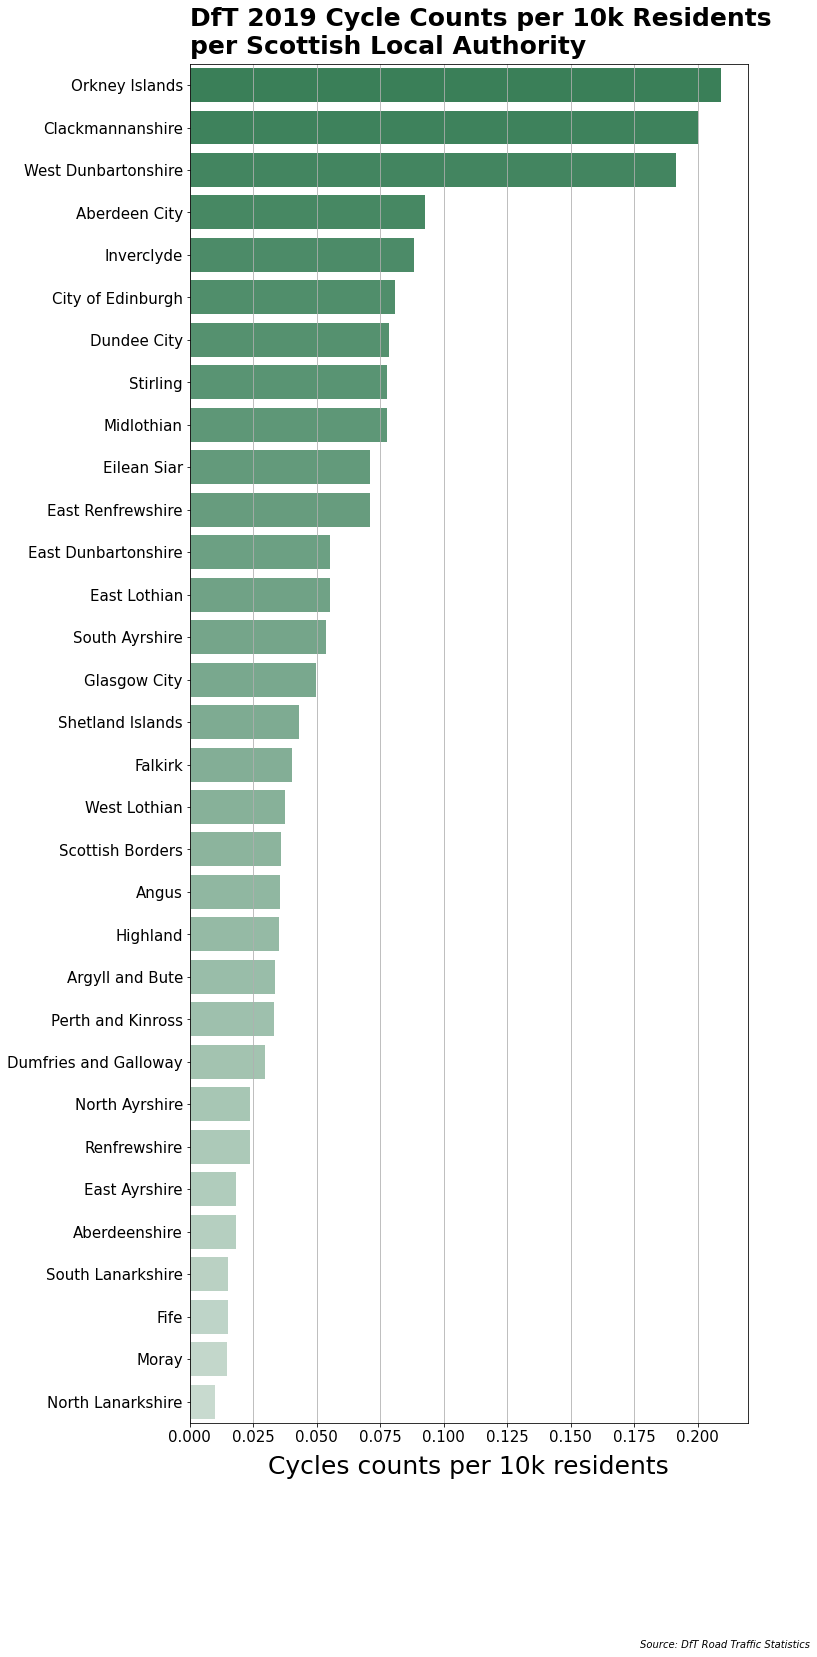

In [11]:
# Horizontal bar plot of bikes per 10k residents
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 25))
pal = sns.light_palette("seagreen", n_colors=40, reverse=True)
sns.barplot(x = bikes_per_10k, y = bikes_per_10k.index, palette=pal)
ax.set_title("DfT 2019 Cycle Counts per 10k Residents \nper Scottish Local Authority",
            pad=10, loc = "left", fontdict={'weight':'heavy', 'color':'black'}, fontsize=25)
ax.set_ylabel("")
ax.set_xlabel("Cycles counts per 10k residents", fontsize=25, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figtext(x=.75, y=0, 
            s='Source: DfT Road Traffic Statistics', 
            fontdict={'style':'oblique', 'color':'black'})
plt.grid(which='major', axis='x')
plt.show()

---

# 🚵🏽‍♀️ Bikes observed per 10k residents per local authority - projected on a map of Scotland - for 2019

To perform this more complex visualisation, we needed to acquire [topographical data](https://github.com/martinjc/UK-GeoJSON) (in TopoJSON format) so that we could that we convert into a map using `Folium`, with a focus on authority borders. We played around with the starting position when the map is loaded due to the fact that Scotland has a few far-flung islands up North which can place them out of the initial map box.

Our choropleth map was coloured using population data with a single colour gradient as we thought this would look cleaner and less distracting compared to using multiple colours. We wanted to display the bikes data points on each local authority as circles, and took two different approaches to placing these circles: one was to find the mean of latitude and longitude in our dataset, and the other was to approximate central coordinates for each authority manually (with the Power of Google Maps) which gave us more control on positining.

Using both methods, we realised that as the coordinates in the DfT data set are based on positions on roads, the mean coordinates are heavily biased towards road clusters, which could have unintended or unexpected behaviour when positioning our circles. In that case, it worked out without incident.

We also explored a number of different visual options for the choropleth map by changing 'tiles' (which impacts land and see colours) and finally decided upon the `CartoDB Positron` tiling theme. 

An interesting and initially difficult exercise was parsing the TopoJSON data (which naturally behaves like a dictionary as it is in JSON format) to pull out relevant authority names so we could use them as keys for our visualisation. As the JSON structure was not very intuitive, we had to run through multiple key extractions to finally arrive at the terribly-named `LAD13NM` which represents the name of the local authority.

Ultimately, we were able to project circles located on centralised coordinates per local authority. We had to make some adjustments to the radius by using a scalar multiple of bike observations as the maximum value was 0.2, rendering the circles as mere dots. Thus, we scaled to a high magnitude for clearer visualisation. The reader can see the results and interact with the map below.

In [12]:
# Selecting relevant columns for mapviz
map_cols = ['count_point_id', 'local_authority_name', 'count_date', 'road_name',
            'hour', 'direction_of_travel', 'latitude', 'longitude', 'population']
map_df = df_tidy[map_cols]

In [13]:
# Manually finding central lat and long of each local authority
# Lat_longs data acquired from Google Maps
auth_names = sorted(map_df.local_authority_name.unique())
lat_longs = [[57.148499575046166, -2.0994503154974553],[57.273760025881934, -2.5166643080179645],[56.72768401017168, -2.9246922126651884],[56.09740006583508, -5.505829190157146],[55.95233877595505, -3.188860106840768],[56.14959079238047, -3.7457616021792624],[55.085097679793755, -3.9648777663637222],[56.46547771536677, -2.9702673126999213],[55.465299446108205, -4.307460244966752],[55.950679905225755, -4.21793961543706],[55.943997191276125, -2.7324635644378654],[55.75505725179119, -4.362197202163319],[58.24343874214309, -6.382783267363518],[56.00349190992439, -3.7933138794341983], [56.246895135851844, -3.087199713717091],[55.85890878015006, -4.246879570599694],[57.47148264549703, -4.918077719700579],[55.910241417028985, -4.73843337649973],[55.8380756961132, -3.091164797971764],[57.507658214268204, -3.2238412189671544], [55.72279452380807, -4.743315946865488], [55.87990377885493, -3.943898088843739], [59.02526102084918, -3.006499055095088], [56.55895608244633, -3.8058868668882613], [55.84937262539755, -4.534918906544666], [55.580570268563, -2.726163579854028], [60.33439464263681, -1.2344978915362006], [55.29083618369606, -4.6958972343105625], [55.59988380366663, -3.7749667034686474], [56.22513721244209, -4.338586907406815], [55.982771806368184, -4.5149571176594625], [55.88803749019023, -3.570496063254735]]
coords_dict = dict(zip(auth_names, lat_longs)) 
coords_df = pd.DataFrame.from_dict(coords_dict, orient='index', columns=['cent_lat', 'cent_long'])
coords_df.reset_index(level=0, inplace=True)
coords_df.rename(columns={'index':'local_authority_name'}, inplace=True)

In [14]:
# Calculating mean lat and long of each local authority from DfT data
coords_df_tidy = df_tidy[['local_authority_name', 'latitude', 'longitude']]
coords_df_tidy = coords_df_tidy.groupby('local_authority_name')[['latitude', 'longitude']].mean()
coords_df_tidy.rename(columns={'latitude':'cent_lat', 'longitude':'cent_long'}, inplace=True) # Renaming columns
coords_df_tidy.reset_index(level = 0, inplace = True)

⚠️ **Please note warning in code below**

In [15]:
# Full outer SQL join of map_df and coords_df_tidy
# WARNING: this operation is idempotent so repeated runs will keep adding cent_lat and cent_long columns
# Must restart kernel if this needs to be run again 
map_df = pd.merge(map_df, coords_df_tidy, on='local_authority_name', how='outer')

In [16]:
# Matching DfT authority names with external authority names
# JSON file is of local authority borders for choropleth map
# Line(s) 7: Martin Chorley, Bob Harper, Charles Boutaud
# URL: https://github.com/martinjc/UK-GeoJSON
# Accessed on 7th December 2020

auth_geo = os.path.join(os.getcwd(), 'data/local_auth.json')
with open(auth_geo) as f:
    scotland_topo = json.load(f)
topo_names = []
for idx in range(32):
    topo_names.append(scotland_topo['objects']['lad']['geometries'][idx]['properties']['LAD13NM'])

In [17]:
# Initialise map of Scotland
scotland_bright = folium.Map(location=[57.8906712, -4.2026458], zoom_start=6.25, tiles='cartodbpositron')

In [18]:
# Create choloropleth of population data
# Code adapted from reference:
# Line(s) 5-25: Amanda Iglasias Moreno
# URL: https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392
# Accessed on 7th December 2020
choropleth = folium.Choropleth(geo_data = scotland_topo,              
    topojson = 'objects.lad',
    key_on ='feature.properties.LAD13NM',
    data = map_df,
    columns = ['local_authority_name', 'population'], 
    name ='choropleth',                                   
    fill_color = 'Blues', 
    fill_opacity = 1, # Prev 0.7
    line_opacity = 0.5, # Prev 0.2
    highlight = True,
    legend_name='Population',
    smooth_factor=0,
).add_to(scotland_bright) # Prev scotland

# Add labels indicating local authority name
# This will allow you to hover over any part of a local authority to see name
style_function = "font-size: 12px"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD13NM'], style=style_function, labels=False))

# Add layer control
folium.LayerControl().add_to(scotland_bright)

⚠️ **Please note warning in code below**

In [19]:
# Tidying up dedicated dataframe for our bikes visualisation
bikes_viz_df = bikes_per_10k.to_frame()
bikes_viz_df.rename(columns={0:'bikes_10k'}, inplace=True)
bikes_viz_df.reset_index(level=0, inplace=True) # Resetting index

# WARNING: this operation is idempotent so repeated runs will keep adding cent_lat and cent_long columns
# Must restart kernel if this needs to be run again 
bikes_viz_df = pd.merge(bikes_viz_df, coords_df_tidy, on='local_authority_name', how='outer')

In [20]:
# Add circles whose sizes represent bikes per 10k residents
# Code adapted from reference:
# Line(s) 8-17: Sunny Solanki
# URL: https://coderzcolumn.com/tutorials/data-science/interactive-maps-choropleth-scattermap-using-folium
# Accessed: 7th December 2020 
for auth_name in auth_names:
    folium.Circle(
        location = [bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['cent_lat'].values[0], 
                bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['cent_long'].values[0]],
        radius = float(bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['bikes_10k'].values[0]*5e4),
        color = 'mediumseagreen',
        fill_color = 'mediumseagreen',
        popup = f"2019 Bike density per 10k residents: {round(bikes_viz_df.loc[bikes_viz_df['local_authority_name'] == auth_name]['bikes_10k'].values[0], 3)}",
        tooltip=auth_name
    ).add_to(scotland_bright)

### DfT 2019 Cycle Density per 10k Residents per Scottish Local Authority

**How can you interact with this?**
* Zoom in and out
* Move around with mouse-drag
* Hover over local authorities to see name
* Click on green circles to see bike density values

In [21]:
# Run this to see final map
scotland_bright

---

# 📅 Distribution of vehicle counts by month from 2000 to 2019

As part of a wider series of visualisations covering the entire range of vehicles, we wanted to explore distribution of vehicle observations per calendar month (within the range of possible months) and if they differed throughout the year. 

This required a slightly more complex `DateTime` transformation to our tidy dataframe such that we could extract the name of the month to be used in our visualisation. The initial visualisation, while valid, made it difficult to see an interesting trend (coming up soon) as the months were not in chronological order. Converting the `month` column to `Categorical` followed by a sort operation on the entire dataframe let us arrive at the appropriate order.

Observation frequencies increased by vehicle in the following order: bikes, motorcycles, buses, HGVs, LGVs, and obviously, cars. We will note the same trend in a latter exploration where we consider distribution across time of day. The key insight here is across the year the observation trends do not change by vehicle. It is also worth noting that the nominal number of observations for any vehicle seemed to dip on specific months. Given the consistency, it seems like the lack of observations or missingness does not seem to be dependent on the vehicles themselves.

This prompted a follow-on hypothesis, as we can think of the set-up such that DfT do not go out to look for specific vehicles (if this were the case, missingness would be dependent on vehicles and the distributions would vary). Our hypothesis is that observations are a function of the different types of road (as we define in our tidy dataframe), given no other data.

In [25]:
# Defining months for ordering purposes
months = ["March", "April", "May", "June", "July", "August",
          "September", "October", "November"]

# Extract relevant columns for observing variation of counts
# over the different months for different vehicles
vehicle_cols = ['count_date', 'bikes', 'motorcycles', 'cars', 'buses', 'lgvs', 'hgvs']
vehicle_df = df_tidy.copy()[vehicle_cols]

# Create new column for month name
vehicle_df.loc[:,'month'] = vehicle_df['count_date'].dt.month_name()

# Ordering month_df chronologically
vehicle_df.loc[:,'month'] = pd.Categorical(vehicle_df['month'], categories=months, ordered=True)
vehicle_df.sort_values(by='month', inplace=True)

In [26]:
vehicle_df

,count_date,bikes,motorcycles,cars,buses,lgvs,hgvs,month
230492,2000-03-24,0,0,125,1,22,12,March
207000,2015-03-19,2,0,142,4,46,12,March
206999,2015-03-19,3,1,431,3,27,0,March
115185,2016-03-21,0,0,2,0,3,0,March
115186,2016-03-21,0,0,6,0,5,3,March
...,...,...,...,...,...,...,...,...
24463,2015-11-03,2,0,231,1,41,5,November
24464,2015-11-03,2,0,258,1,37,6,November
24465,2015-11-03,3,1,263,4,28,3,November
61132,2017-11-01,0,0,26,0,3,5,November


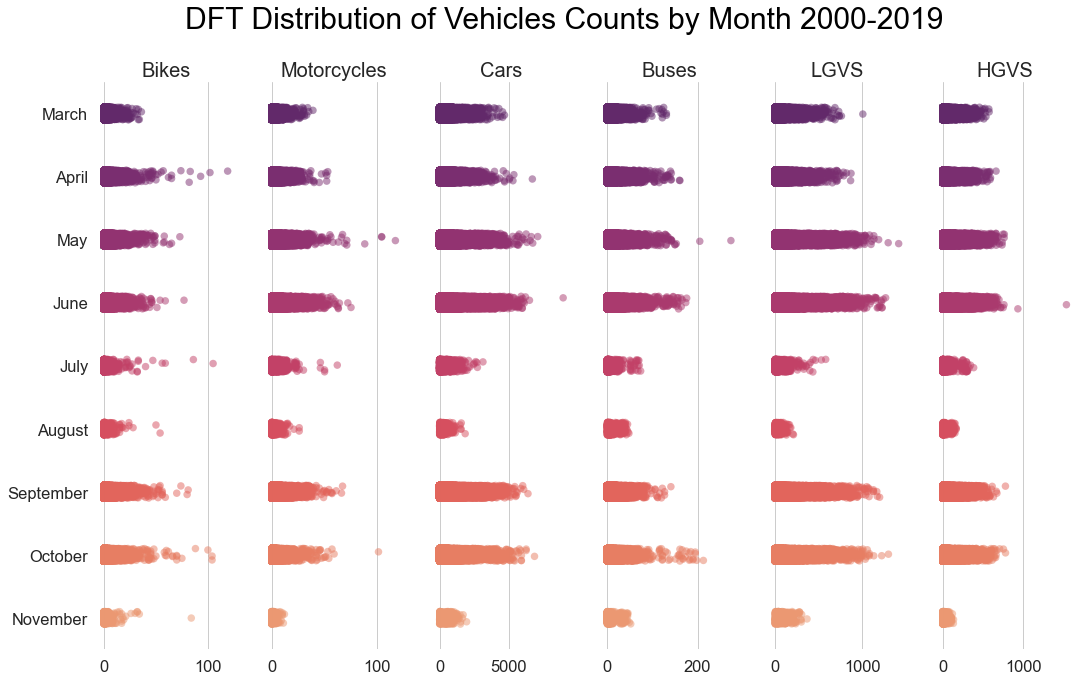

In [27]:
sns.set_theme(style='whitegrid', font_scale=1.5)

# Create the PairGrid
vg = sns.PairGrid(vehicle_df.sort_values('cars', ascending=False),
                 x_vars=vehicle_df.columns[1:-1], y_vars=['month'],
                 height=10, aspect=.25)
plt.subplots_adjust(top=.875)
vg.fig.suptitle("DFT Distribution of Vehicles Counts by Month 2000-2019",  
                fontdict={'weight':'bold', 'color':'black'},
                fontsize=30)

# Draw a scatter plot using stripplot function
vg.map(sns.stripplot, size=7.5, orient='h', marker='o',
       palette='flare_r', linewidth=1, edgecolor='none',  alpha=.5)

# Use semantically meaningful titles for the columns
titles = ["Bikes", "Motorcycles", "Cars", "Buses",
          "LGVS", "HGVS"]

for ax, title in zip(vg.axes.flat, titles):
    # Set a different title for each axes
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

sns.despine(left=True, bottom=True)

---

# 🛣 Distribution of monthly observations counts by road type from 2000 to 2019

First we looked at the number of unique A, B and M roads in Scotland as it is difficult - from this dataset - to estimate the number of unique U/C roads. We report back 278 A roads, 206 B roads, and 9 M roads.

To make the visualisation work, we needed to widen our dataframe so that the structure would look similar to that for vehicle types, i.e. `road_type` had to be cast into columns. The main transformation here was in pivoting our tidy dataframe wider, and aggregating based on the length of resulting cells; `NaN` values were replaced with 0. We had to repeat the previous transformation to make months chronologically ordered.

Instead of a categorical scatter plot we decided to use a horizontal bar plot, including error bars. We immediately noticed a few elements of interest. Firstly, for months were fewer vehicles were observed, for certain types of roads, no counts were at all all (for example, there were not observations related to M roads for any August across our dataset). Additionally, there the error bars varied quite substantially for August.

This leads us to hypothesise that, as a manual exercise, observations are also a function of availability of DfT staff. As July and August are school holidays in the UK (and also general vacation time), it is likely that most working parents (and non-parents) will be away which adds credence our hypothesis. If we had to make a point about November, which also sees a large number of missing observations, it is likely based on the run-up to Christmas and plummeting temperatures. Who wants to stand outside spotting cars during this time? (Trains are a different matter.)

In [28]:
# Quick script to print out unique A, B and M roads in Scotland
extract_road_letters = np.vectorize(lambda string: string[0])

for road_counts in zip(*np.unique(extract_road_letters(df_tidy.road_name.unique()), return_counts = True)):
    if road_counts[1] > 1:
        print(f"There are {road_counts[1]} {road_counts[0]} roads.")

There are 278 A roads.
There are 206 B roads.
There are 9 M roads.


In [29]:
# Extract relevant columns for observing variation of counts
# over the different months for different road_types
roads_cols = ['count_date', 'road_type']
roads_df = df_tidy[roads_cols]

In [30]:
# Pivoting data wider so M, A, B, C, U become columns
roads_df = roads_df.pivot_table(index=['count_date'], columns=['road_type'], aggfunc=len, fill_value=0)

In [31]:
roads_df.reset_index(level=0, inplace=True)

In [32]:
# Making type_df chronologically ordered
roads_df['month'] = roads_df['count_date'].dt.month_name()
roads_df['month'] = pd.Categorical(roads_df['month'], categories=months, ordered=True)
roads_df.sort_values(by='month', inplace=True)

In [33]:
# Reordering type_df columns
roads_cols = ['count_date', 'month', 'M', 'A', 'B', 'C', 'U']
roads_df = roads_df.reindex(columns=roads_cols)

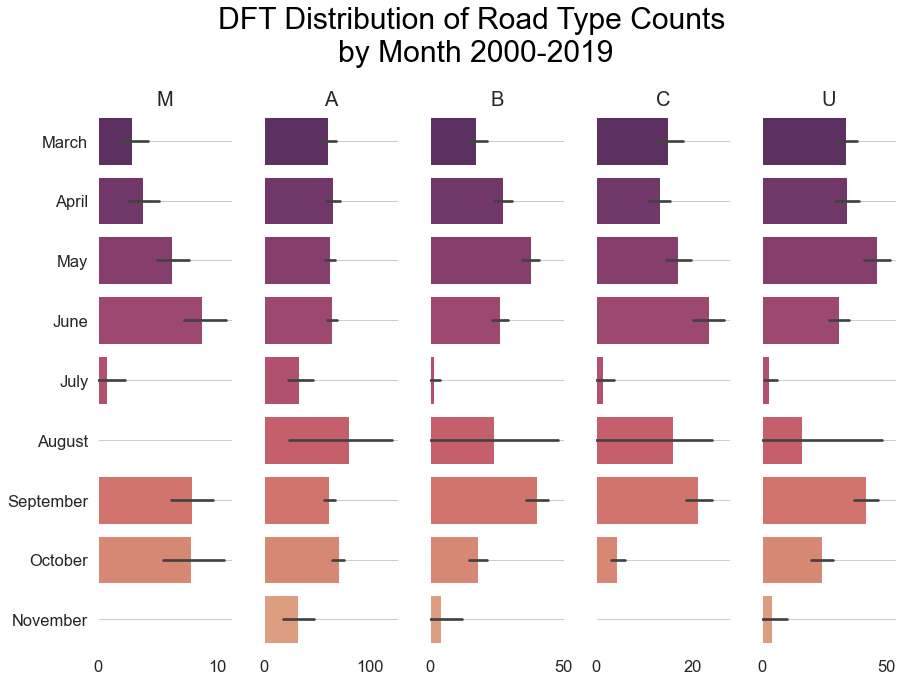

In [34]:
sns.set_theme(style='whitegrid', font_scale=1.5)
# Create the PairGrid
roads_g = sns.PairGrid(roads_df.sort_values('A', ascending=False),
                 x_vars=roads_df.columns[2:], y_vars=['month'],
                 height=10, aspect=.25)
plt.subplots_adjust(top=.835)
roads_g.fig.suptitle("DFT Distribution of Road Type Counts \nby Month 2000-2019",  
                fontdict={'weight':'bold', 'color':'black'},
                fontsize=30)


# Draw a scatter plot using stripplot function
roads_g.map(sns.barplot, palette="flare_r")

# Use semantically meaningful titles for the columns
titles = ["M", "A", "B", "C", "U"]

for ax, title in zip(roads_g.axes.flat, titles):
    # Set a different title for each axes
    ax.set_title(title, fontsize=20)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_ylabel("")
    ax.set_xlabel("")
    
sns.despine(left=True, bottom=True)

---

# 🙊 Observations of ~HGVs~ bikes on ~unclassified roads~ motorways in Scotland from 2000 to 2019

Out of curiosity, we wanted to explore the count point locations of HGVs (because they need some love) in Scotland, with a particular emphasis on unclassified roads (as we hypothesised it would be unlikely to see too many of them on such roads).

We wanted to shake things up from our previous map visualisation, and utilised a **shapefile** instead, based on the road network for Scotland. Due to difficulties acquiring this data from the official source (spatial data from data.gov.uk), we found an alternative [source](https://mapcruzin.com/free-scotland-arcgis-maps-shapefiles.htm). We needed to use the `Shapely` library to convert latitude and longitude coordinates from our tidy dataframe, into `Point` objects that `GeoPandas` can parse for plotting. 

The resulting visualisation wasn't as interesting or as scandalous as we thought it would be, so we considered another investigation: would you ever expect to observe bikes on motorways, given that it is illegal for them to be on such roads?

As can be seen in the following map, it turned out that particular stretches of some motorways bore witness to appreciable numbers of bikes on specific dates:
* M8 on 11th June 2007
* M90 on 11th April 2000, and again on 23rd June 2000

Despite our best efforts, we could not find any news or cycling events to corroborate, although there was [one article](https://www.glasgowtimes.co.uk/news/12784474.holiday-misery-for-m8-drivers/) which mentioned roadworks and a speed reduction to 40mph (which would be make it possible to cycle without a death wish) but those were not expected to begin until much later. It either remains a mystery, or a massive error (which is somewhat unlikely given the repeated observations throughout the day).

In [38]:
# Unique roads, because we can
unique_motorways = df_tidy.loc[df_tidy.road_type == 'M'].road_name.unique()
unique_motorways

array(['M8', 'M9', 'M80', 'M77', 'M74', 'M876', 'M73', 'M90', 'M898'],
      dtype=object)

In [36]:
# Extracting HGV-only data
bikem_cols = ['count_date', 'hour', 'road_name', 'road_type', 'latitude', 'longitude', 'bikes']
bikem_df = df_tidy[bikem_cols]
bikem_df = bikem_df.loc[bikem_df['bikes'] > 0]

In [37]:
bikem_df.loc[(bikem_df['road_type']=='M')]

,count_date,hour,road_name,road_type,latitude,longitude,bikes
31644,2007-06-11,7,M8,M,55.867747,-4.210061,1
31645,2007-06-11,8,M8,M,55.867747,-4.210061,2
31646,2007-06-11,9,M8,M,55.867747,-4.210061,15
31647,2007-06-11,10,M8,M,55.867747,-4.210061,15
31648,2007-06-11,11,M8,M,55.867747,-4.210061,24
31649,2007-06-11,12,M8,M,55.867747,-4.210061,24
31650,2007-06-11,13,M8,M,55.867747,-4.210061,4
31651,2007-06-11,14,M8,M,55.867747,-4.210061,4
31652,2007-06-11,15,M8,M,55.867747,-4.210061,15
31653,2007-06-11,16,M8,M,55.867747,-4.210061,15


In [39]:
# Creating Point objects for plotting HGV counts and their locations
# on gpd map
geometry = [Point(xy) for xy in zip(bikem_df['longitude'], bikem_df['latitude'])]
# Specifying coordinate reference system
crs = {'init': 'EPSG:4326'}
bikem_df.drop(['latitude', 'longitude'], inplace=True, axis = 1) # drop unnessecary cols

In [40]:
geo_df = gpd.GeoDataFrame(bikem_df, crs = crs, geometry = geometry) # Create geodf

/Users/azfarul/opt/anaconda3/envs/pyprog/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [41]:
# Read in external shape file of Scottish roads
# Line(s) 5: Michael R. Meuser
# URL: https://mapcruzin.com/free-scotland-arcgis-maps-shapefiles.htm
# Accessed on 7th December 2020
scotland_roads = gpd.read_file('data/roads.shp')

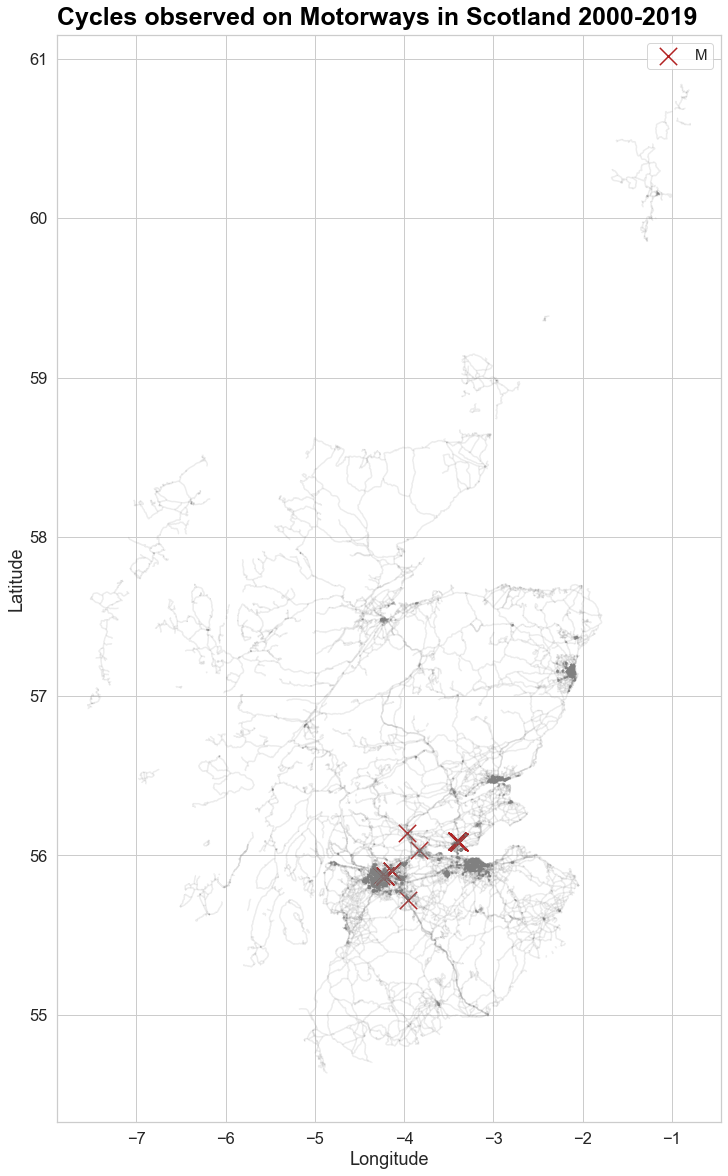

In [47]:
# Create map showing road network, and plot bike observations (on M roads) 
fig, axis = plt.subplots(figsize = (12, 20))
scotland_roads.plot(ax = axis, color = 'gray', alpha = 0.15)
axis.set_ylabel('Latitude')
axis.set_xlabel('Longitude')
axis.set_title("Cycles observed on Motorways in Scotland 2000-2019",
            pad=10, loc = "left", fontdict={'weight':'heavy', 'color':'black'}, fontsize=25)
geo_df[geo_df['road_type'] == 'M'].plot(ax = axis, markersize = 300, color = 'firebrick', marker = 'x', label = 'M')
plt.legend(prop = {'size': 15})
plt.show()

---

# ⏰ Distribution of vehicle counts per hour of day 

By answering one of the provided questions, we wanted to differentiate our response with a particularly nice-looking plot. We decided to use the colour scheme and some formatting from the `FiveThirtyEight` theme available in `matplotlib`. The concept was to use a faceted plot based on type of vehicle but due to challenges using Seaborn's built-in `FacetGrid`, to get our desired output we resorted to rolling our own using our favourite Python iterator (true story), `enumerate`.

In previous investigations we created wider dataframes, but in this instance, we needed a longer dataframe to ensure that the vehicle types (previously each vehicle was in its own column) were captured in a single categorical column. Counts were then summed by hour of day. We manually ordered the distribution plots in descending order of raw observations.

As can be seen, there are expected peaks in the morning primarily due to commuter traffic, and in the evening. The evening peaks are higher as it would also include leisure traffic after a hard working day. HGVs were an anomaly, and we surmise that is because their work involves them driving to and from depots and distribution centres, and what better time to do so when other traffic is quieter.

As expect many others to try and visualise the same graph, we wanted to differentiate it by manually controlling the entire theme (with `FiveThirtyEight` as our base): note the use of light alpha-filled densities, and what we have termed a 'Hollywood'-esque (somewhat inspired by Hitchcock's *North by Northwest*) rendering of the vehicle type on the density area itself.

In [48]:
# Create time of day dataframe
tod_df = df_tidy[['hour'] + new_names] # Extracting relevant variables
tod_df = tod_df.groupby('hour').sum()  # Find total counts of each vehicle at every hour
tod_df.reset_index(level=0, inplace=True) # Index with numbers not names
tod_df = tod_df.melt(id_vars='hour', var_name='vehicle_type') # Pivot longer
tod_df.vehicle_type = tod_df.vehicle_type.astype('category')  # Converting datatype to categorical

In [49]:
# Define relevant data to plot
x = tod_df.hour.unique()
y1 = tod_df.loc[tod_df.vehicle_type=='cars']['value']
y2 = tod_df.loc[tod_df.vehicle_type=='lgvs']['value']
y3 = tod_df.loc[tod_df.vehicle_type=='hgvs']['value']
y4 = tod_df.loc[tod_df.vehicle_type=='buses']['value']
y5 = tod_df.loc[tod_df.vehicle_type=='motorcycles']['value']
y6 = tod_df.loc[tod_df.vehicle_type=='bikes']['value']
y = [y1, y2, y3, y4, y5, y6] # Amalgamate into single list

In [50]:
# Parameters for plotting
labels = ["CARS", "LGVS", "HGVS", "BUSES", "MOTORBIKES", "BIKES"]
xticks_ = np.arange(7, 19)

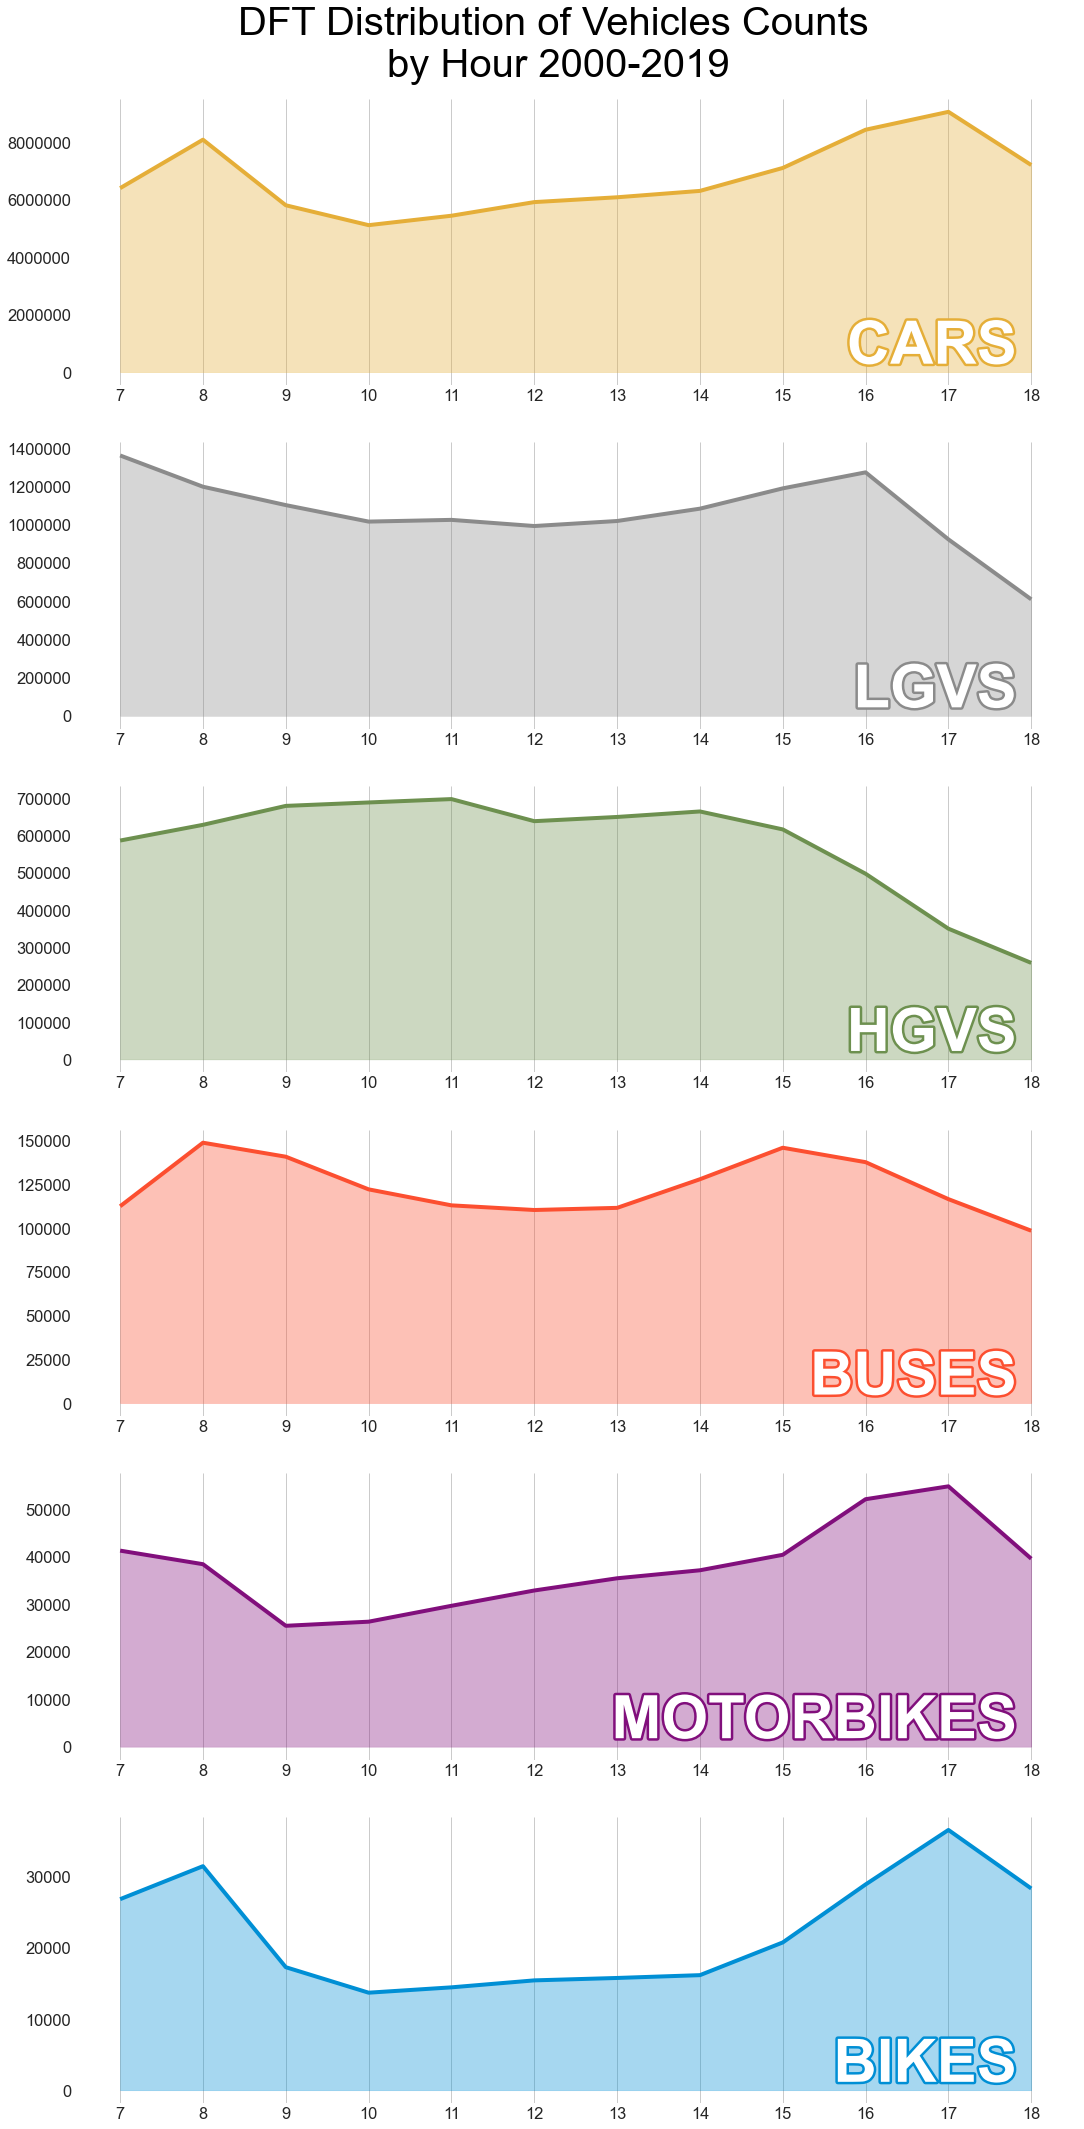

In [51]:
# Make graph stunning
plt.style.use('fivethirtyeight')

# Plotting facetgrid manually
fig, axes = plt.subplots(6, 1, sharex=False, sharey=False, figsize=(16, 32), facecolor='white')
plt.subplots_adjust(top=.94)

fig.suptitle("DFT Distribution of Vehicles Counts \nby Hour 2000-2019",  
                fontdict={'weight':'bold', 'color':'black'},
                fontsize=40)

# FiveThirtyEight colours manually selected for hue
hues = ['#e5ae38', '#8b8b8b', '#6d904f', '#fc4f30', '#810f7c', '#008fd5']

for i, ax in enumerate(axes):
    sns.lineplot(data=tod_df, x='hour', y=y[i], ax=ax, hue='vehicle_type')
    ax.fill_between(x, y[i], color=hues[i], alpha=0.35)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(xticks_),
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f')),
    ax.get_legend().remove()
    t = ax.annotate(f"{labels[i]}", 
                xy=(10,10), 
                xycoords='data', 
                textcoords='axes fraction', 
                xytext=(.94,.075),
                ha='right',
                fontsize=60,
                fontweight='bold',
                color='white')
    t.set_path_effects([path_effects.Stroke(linewidth=5, foreground=hues[i]),
                       path_effects.Normal()])
    ax.set_facecolor("white")
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    sns.despine(left=True, bottom=True)

---

# ⚠️ TODO
* Add a "future work" section where we walk through our approach of estimating U/C roads only given the dataset that we have
* General bullet points on rejected questions and our approach

# ~Q1: Bar chart of [X] longest roads showing start and end locations~

### Method
* Filter by distinguishing road name 
* Ignore U and C roads 
* We have start and end junctions (general locations)
* How do we calculate distance?
    1. Add up link lengths
    2. Verify with Google Maps
    

# ~Q2: Local authorities managing number of roads - mapviz - fixed point in time~

### Outcome
* 2019 map of roads managed
* Static map of Scotland with gradient colour scheme

### Method
* Group by `local_authority_name`, `count_id`
* Break down total number of roads per authority into `road_names`
* Possible weight matrix to give larger, busier roads a larger influence in the map - don't want to give U and C thes same weighting as M and A roads
* In `road_name` variable, cut string such that it's only a single character

### Stretch and Challenge
* Maintenance data to observe which authority spends the most on maintainance

### Extra Packages:
* folium
* geopandas

### Outcome
* x-axis: discrete vehicle type data e.g.  cars, bikes, buses, hgvs, lgvs etc
* y-axis: type of road e.g. M, A, B, C, U
* Scatter point for each category where size indicates prevalence of that type of vehicle on that type of road
* Slider which shows variation of data over [X] years


### Method
* Group C and U roads
* Normalize scatter points by \pi*R^2


### Stretch and Challenge
* We have dotted line outline of average of previous 5 years giving the reader some indication of growth/reduction
* x-axis: as emojis


### Extra packages
* plotly - used to vary the datapoints


